<a href="https://colab.research.google.com/github/94jjiisu/Data-analysis/blob/master/bean_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [170]:
# !pip install -U pandas-profiling
# !pip install eli5
# !pip install pdpbox
# !pip install shap

In [171]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144
%matplotlib inline
from pandas_profiling import ProfileReport


from sklearn.model_selection import train_test_split, validation_curve, RandomizedSearchCV, GridSearchCV
from scipy.stats import randint, uniform

import graphviz

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, LabelEncoder

from sklearn.metrics import plot_confusion_matrix, accuracy_score, classification_report, f1_score, roc_auc_score, roc_curve

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier


from sklearn.decomposition import PCA

import eli5
from eli5.sklearn import PermutationImportance
import warnings
warnings.filterwarnings('ignore')

warnings.simplefilter(action='ignore', category=FutureWarning)

In [172]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [173]:
filename = "/content/drive/MyDrive/DS_camp/session2/Dry_Bean_Dataset.xlsx"

df = pd.read_excel(filename)

In [174]:
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [175]:
df.isna().sum().sort_values()

Area               0
ShapeFactor3       0
ShapeFactor2       0
ShapeFactor1       0
Compactness        0
roundness          0
Solidity           0
ShapeFactor4       0
Extent             0
ConvexArea         0
Eccentricity       0
AspectRation       0
MinorAxisLength    0
MajorAxisLength    0
Perimeter          0
EquivDiameter      0
Class              0
dtype: int64

In [176]:
df.duplicated().sum()

68

In [177]:
df.drop_duplicates(keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)

In [178]:
df.Class.value_counts()

DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1860
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: Class, dtype: int64

In [179]:
class_names = ['BARBUNYA',	'BOMBAY',	'CALI',	'DERMASON',	'HOROZ',	'SEKER',	'SIRA']

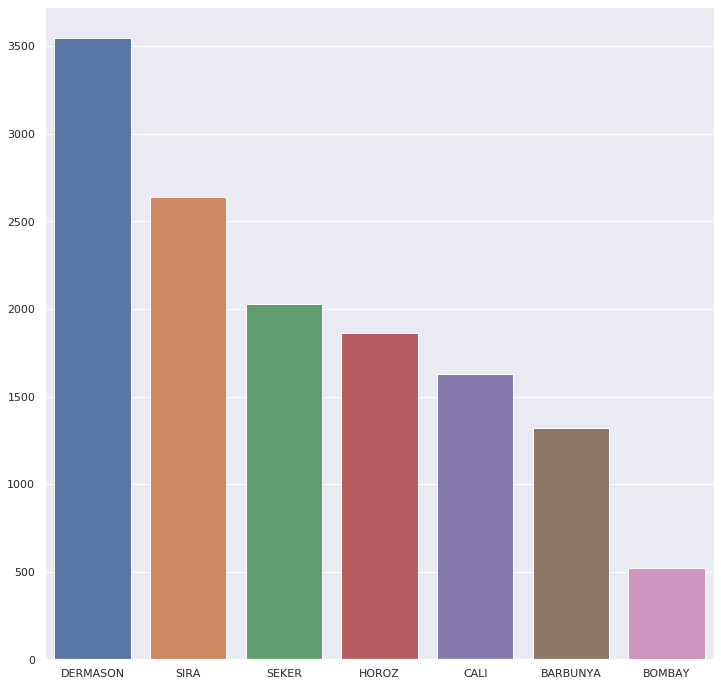

In [180]:
cnt = df.Class.value_counts()
plt.figure(figsize=(12,12))
sns.barplot(x = cnt.index, y = cnt.values);

In [181]:
df.head(3)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER


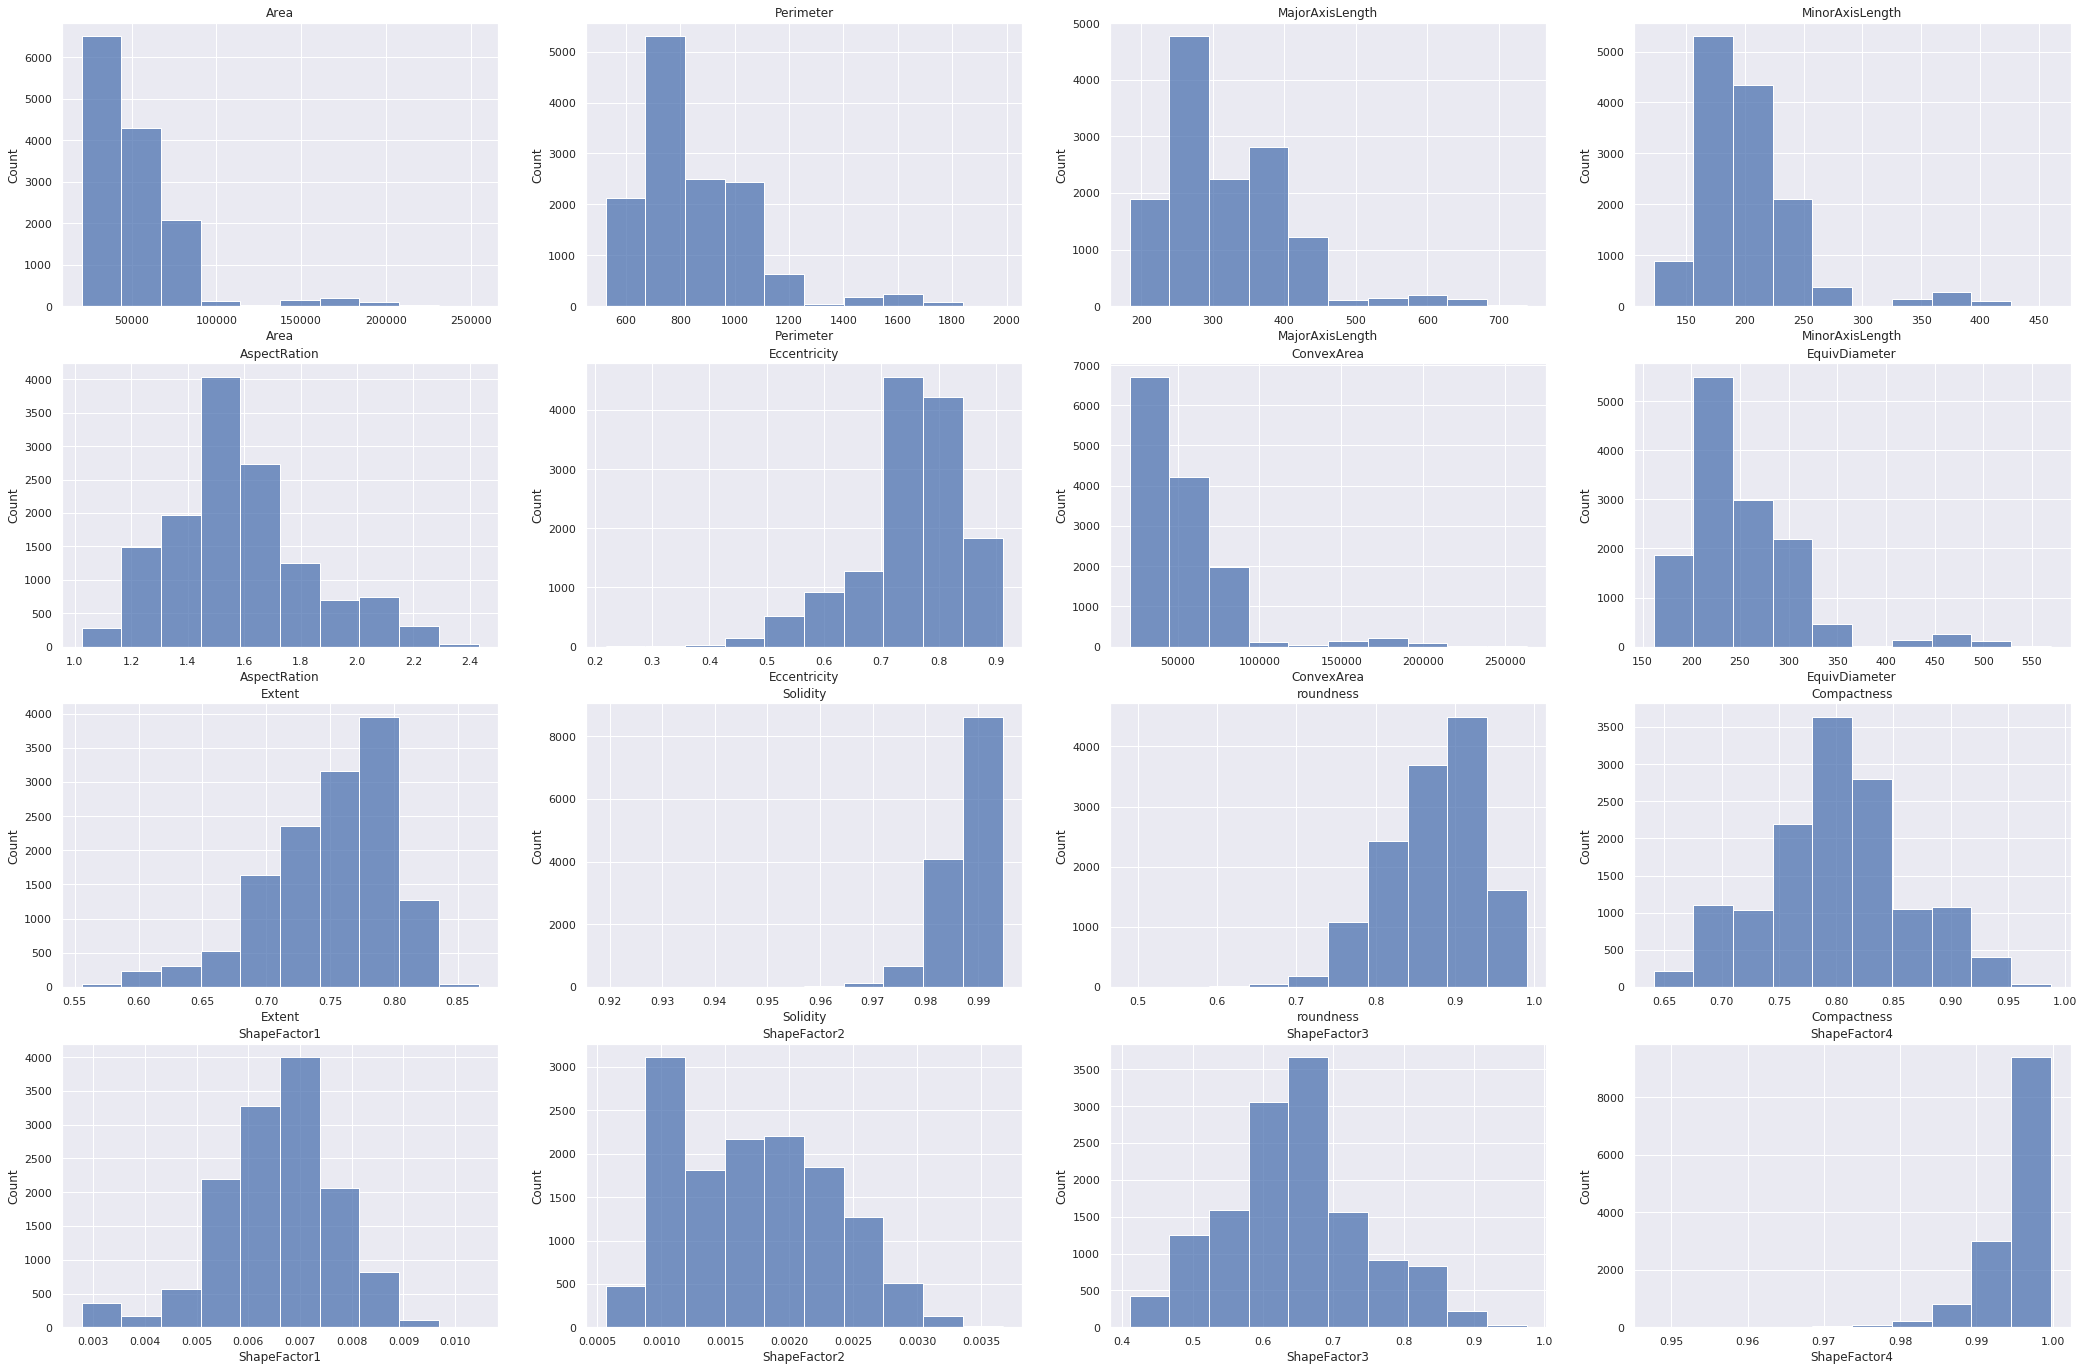

In [182]:
COLUMNS = df.columns.tolist()

feature_cols = COLUMNS[:-1]
sns.set(style='darkgrid')
fig, ax_list = plt.subplots(nrows=4, ncols=4, sharey=False, figsize=(36,24))
ax_list = ax_list.flatten()
for name, ax in zip(feature_cols, ax_list):
     g = sns.histplot(df, x=name, bins=10, ax=ax).set(title=name)

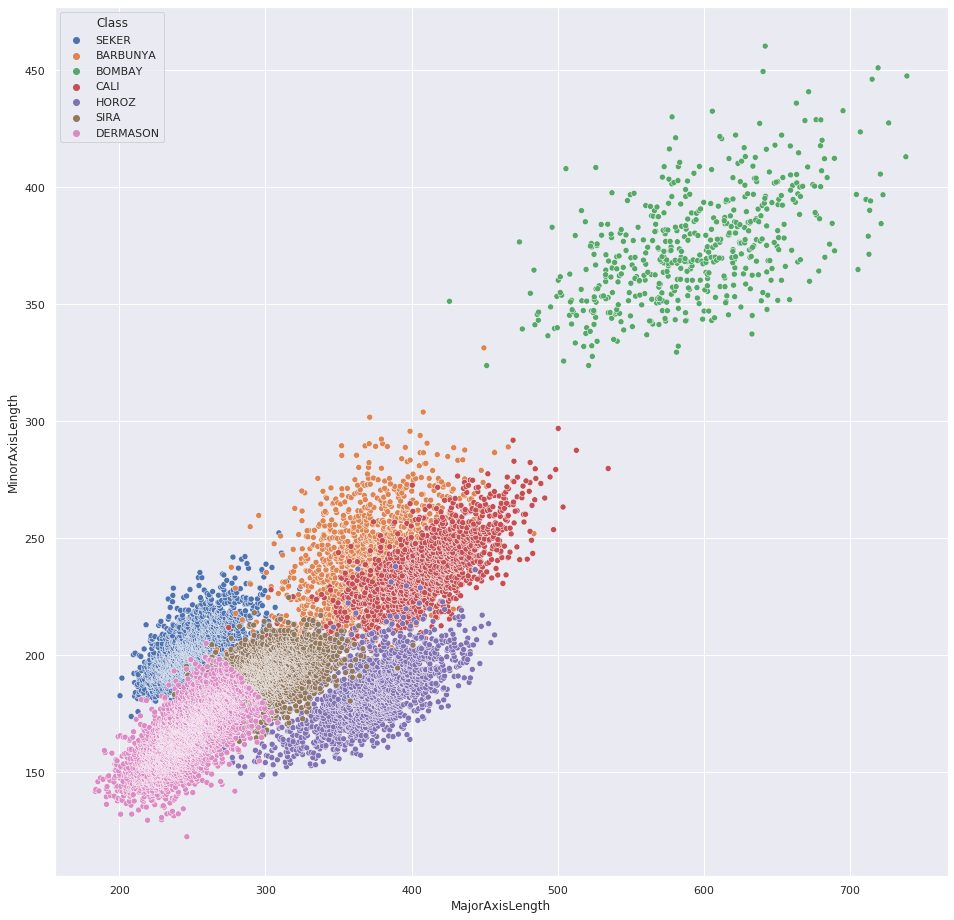

In [183]:
plt.figure(figsize=(16,16))
sns.scatterplot(x=df['MajorAxisLength'], y=df['MinorAxisLength'], hue=df['Class']);

In [184]:
target = 'Class'

label = df[target]
features = df.drop([target], axis=1)

In [185]:
scaler = StandardScaler()
Z = scaler.fit_transform(features)

output = pd.DataFrame(Z, columns=features.columns, index=list(features.index.values))

In [186]:
pca = PCA(2)
df_pca= pca.fit_transform(output)
df_pca = pd.DataFrame(data = df_pca, columns=['PC1', 'PC2'])

In [187]:
df_pca['Class'] = label

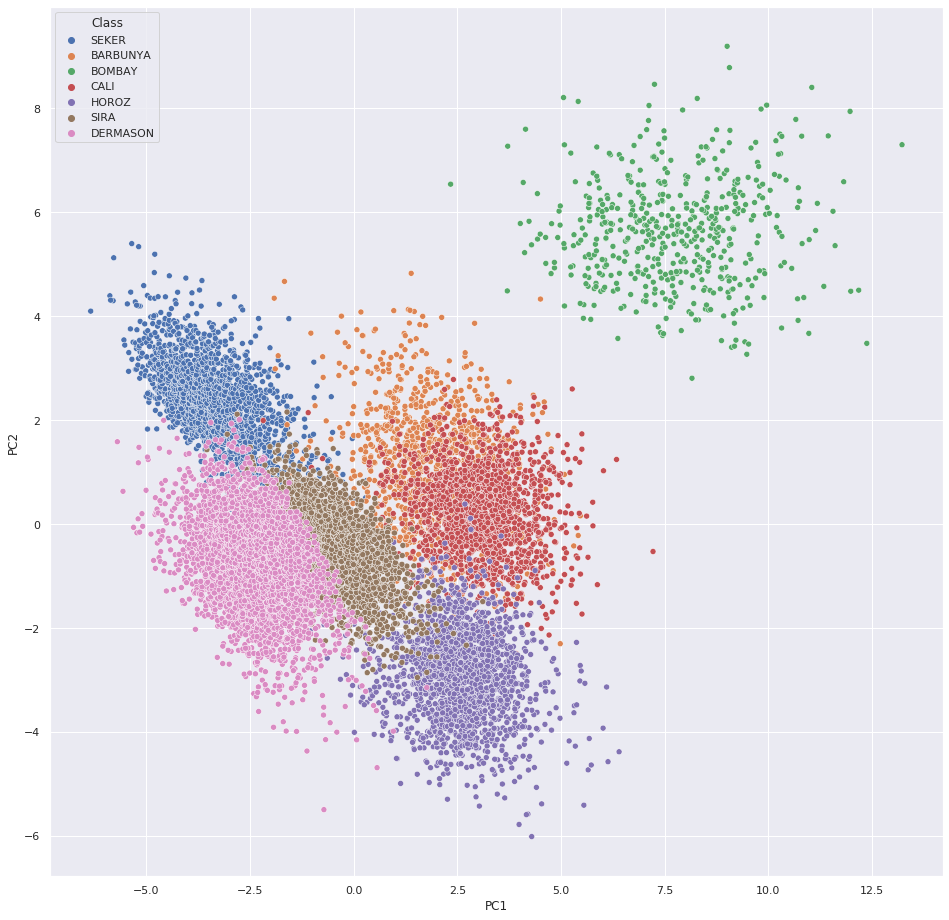

In [188]:
plt.figure(figsize=(16,16))
sns.scatterplot(x = 'PC1', y = 'PC2', data = df_pca, hue = 'Class');

In [189]:
area = df['Area'].groupby(df['Class']).mean().sort_values()

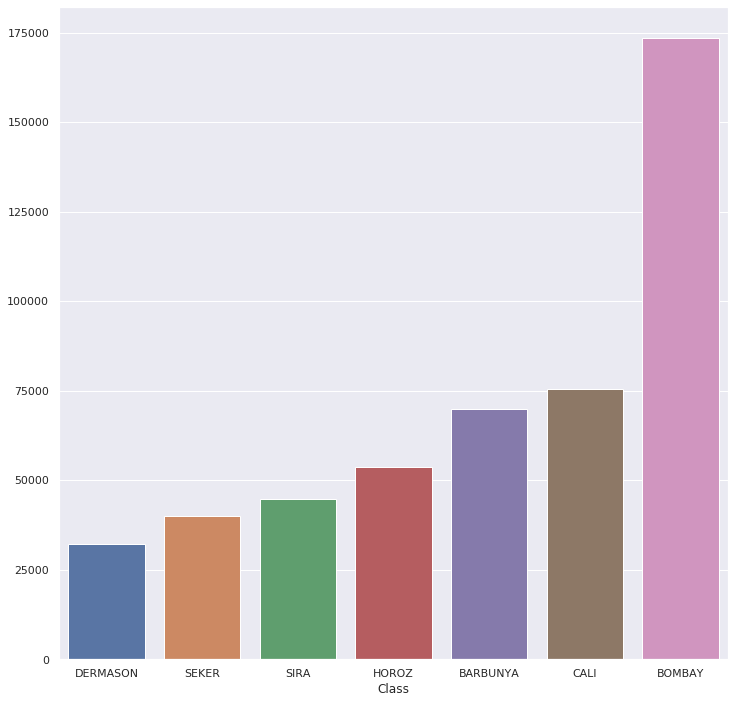

In [190]:
plt.figure(figsize=(12,12))
sns.barplot(x = area.index, y = area.values);

In [191]:
target = 'Class'

train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df[target], random_state=2)

train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)

train.shape, val.shape, test.shape

((8667, 17), (2167, 17), (2709, 17))

In [192]:
train[target].value_counts(normalize=True)

DERMASON    0.261913
SIRA        0.194646
SEKER       0.149648
HOROZ       0.137302
CALI        0.120342
BARBUNYA    0.097612
BOMBAY      0.038537
Name: Class, dtype: float64

In [193]:
val[target].value_counts(normalize=True)

DERMASON    0.261652
SIRA        0.194739
SEKER       0.149515
HOROZ       0.137517
CALI        0.120443
BARBUNYA    0.097370
BOMBAY      0.038763
Name: Class, dtype: float64

In [194]:
test[target].value_counts(normalize=True)

DERMASON    0.261720
SIRA        0.194537
SEKER       0.149871
HOROZ       0.137320
CALI        0.120340
BARBUNYA    0.097822
BOMBAY      0.038391
Name: Class, dtype: float64

In [195]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [196]:
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

predict = dt_clf.predict(X_val)
f1=f1_score(y_val, predict, average='weighted')

print("F1 score: {}" .format(f1))

F1 score: 0.8891375007155944


In [197]:
predict = dt_clf.predict(X_test)
f1=f1_score(y_test, predict, average='weighted')


print("F1 score: {}" .format(f1))

F1 score: 0.8959994964512971


In [198]:
confusion = pd.DataFrame({'Class': test['Class'], 'Predict': predict})
# Create crosstab: ct
ct = pd.crosstab(confusion['Class'], confusion['Predict'])
print(classification_report(predict, test['Class']))
print()
ct

              precision    recall  f1-score   support

    BARBUNYA       0.92      0.86      0.89       281
      BOMBAY       0.99      1.00      1.00       103
        CALI       0.90      0.92      0.91       318
    DERMASON       0.88      0.90      0.89       694
       HOROZ       0.92      0.93      0.92       368
       SEKER       0.95      0.94      0.94       411
        SIRA       0.83      0.82      0.83       534

    accuracy                           0.90      2709
   macro avg       0.91      0.91      0.91      2709
weighted avg       0.90      0.90      0.90      2709




Predict,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Class,,,,,,,
BARBUNYA,243,0,14,0,0,4,4
BOMBAY,1,103,0,0,0,0,0
CALI,22,0,293,0,7,1,3
DERMASON,0,0,0,622,5,13,69
HOROZ,5,0,7,3,342,0,15
SEKER,3,0,1,13,0,385,4
SIRA,7,0,3,56,14,8,439


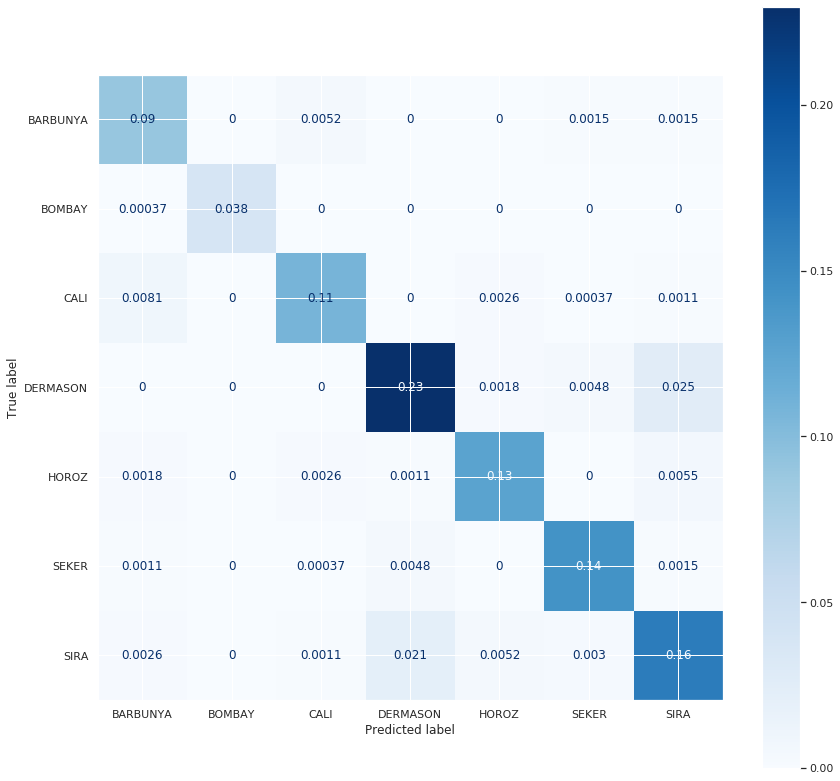

In [199]:
fig, ax = plt.subplots(figsize=(14, 14))
disp = plot_confusion_matrix(dt_clf, X_test, y_test, 
                             display_labels=class_names, cmap=plt.cm.Blues, 
                              ax = ax,
                             normalize='all')

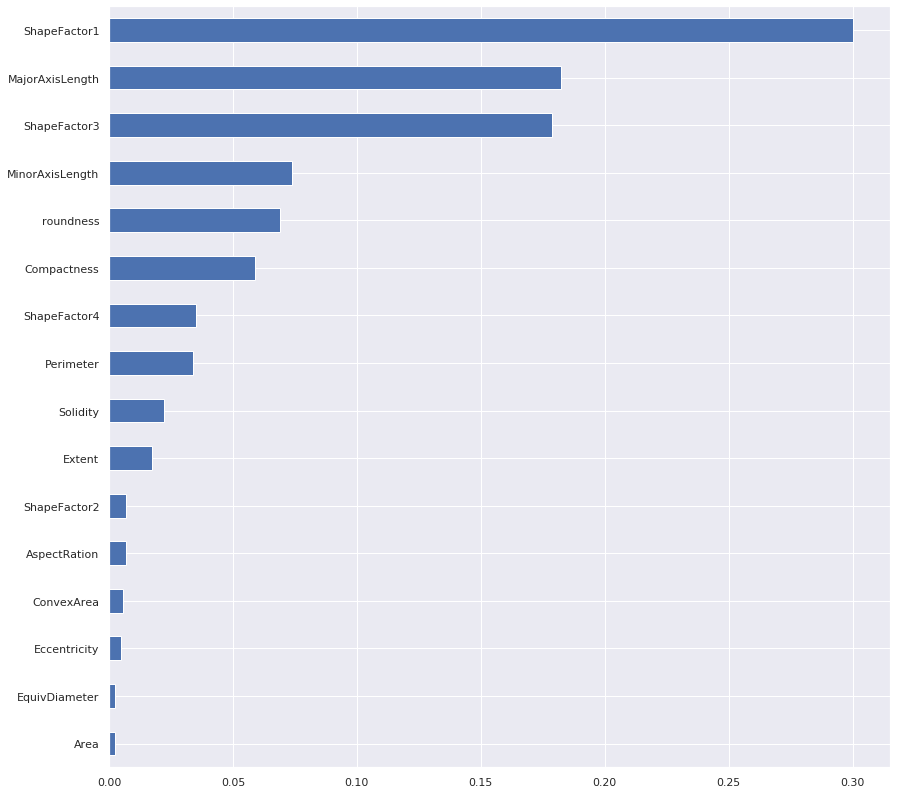

In [200]:
model_dt = dt_clf

importances = pd.Series(model_dt.feature_importances_, X_train.columns)
plt.figure(figsize=(14,14))
importances.sort_values().plot.barh();

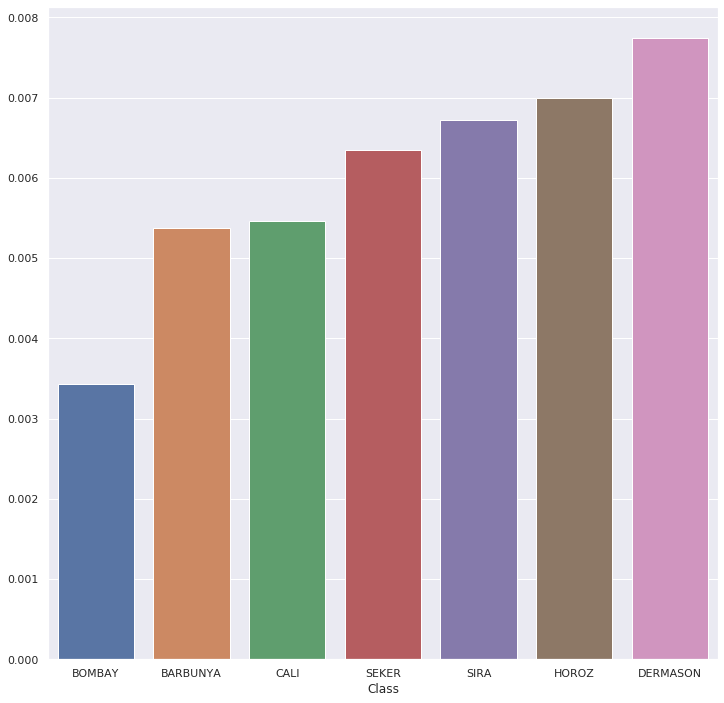

In [201]:
ft1 = train['ShapeFactor1'].groupby(df['Class']).mean().sort_values()
plt.figure(figsize=(12,12))
sns.barplot(x = ft1.index, y = ft1.values);

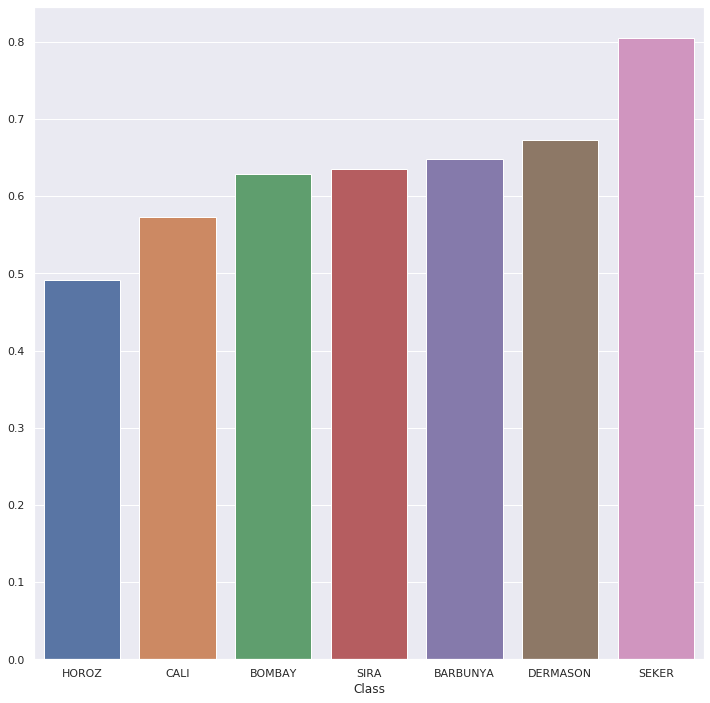

In [202]:
ft3 = train['ShapeFactor3'].groupby(df['Class']).mean().sort_values()
plt.figure(figsize=(12,12))
sns.barplot(x = ft3.index, y = ft3.values);

In [203]:
pipe_tree = make_pipeline(
    RobustScaler(),
    DecisionTreeClassifier(random_state=42)
)

params = {
    'decisiontreeclassifier__class_weight' : [None],
    'decisiontreeclassifier__max_depth' : [16],
    'decisiontreeclassifier__min_samples_leaf' : [6],
    'decisiontreeclassifier__max_features':[12]
}

clf1 = GridSearchCV(
    pipe_tree,
    param_grid=params,
    cv=5,
    n_jobs=-1
    )

clf1.fit(X_train, y_train)


print('최적 하이퍼파라미터: ', clf1.best_params_)
print()
print('accuracy: ', clf1.best_score_)
print()
m0 = clf1.best_estimator_

m0.fit(X_val, y_val)
print('검증 정확도', m0.score(X_val, y_val))
print()
predict = m0.predict(X_val)
f1=f1_score(y_val, predict, average='weighted')

print("F1 score: {}" .format(f1))
print()

최적 하이퍼파라미터:  {'decisiontreeclassifier__class_weight': None, 'decisiontreeclassifier__max_depth': 16, 'decisiontreeclassifier__max_features': 12, 'decisiontreeclassifier__min_samples_leaf': 6}

accuracy:  0.9050430911986668

검증 정확도 0.9413936317489617

F1 score: 0.9414098873698826



In [204]:
test_pred = m0.predict(X_test)

confusion = pd.DataFrame({'Class': test['Class'], 'Predict': test_pred})
# Create crosstab: ct
ct = pd.crosstab(confusion['Class'], confusion['Predict'])

print(classification_report(test_pred, test['Class']))
print()
ct

              precision    recall  f1-score   support

    BARBUNYA       0.90      0.89      0.90       268
      BOMBAY       0.96      1.00      0.98       100
        CALI       0.89      0.93      0.91       311
    DERMASON       0.91      0.89      0.90       724
       HOROZ       0.95      0.94      0.94       376
       SEKER       0.91      0.95      0.93       389
        SIRA       0.86      0.84      0.85       541

    accuracy                           0.90      2709
   macro avg       0.91      0.92      0.91      2709
weighted avg       0.90      0.90      0.90      2709




Predict,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Class,,,,,,,
BARBUNYA,239,0,11,0,1,6,8
BOMBAY,1,100,3,0,0,0,0
CALI,25,0,290,0,10,0,1
DERMASON,0,0,0,642,1,5,61
HOROZ,2,0,4,4,353,0,9
SEKER,1,0,0,26,0,369,10
SIRA,0,0,3,52,11,9,452


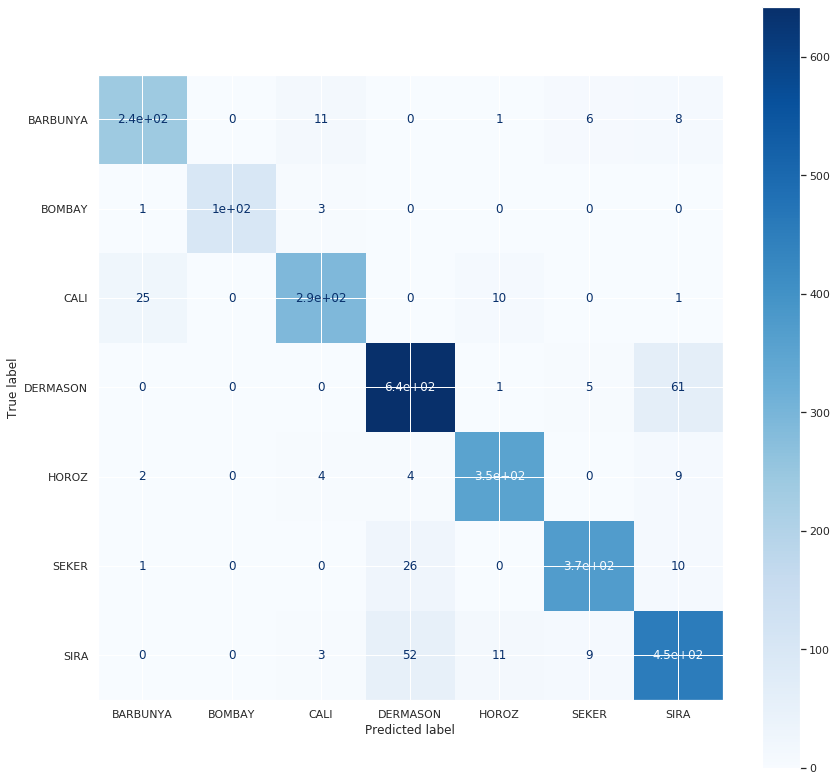

In [205]:
fig, ax = plt.subplots(figsize=(14, 14))
disp = plot_confusion_matrix(m0, X_test, y_test, 
                             display_labels=class_names, cmap=plt.cm.Blues, 
                              ax = ax,
                             )

In [206]:
print('테스트 정확도', m0.score(X_test, y_test))

테스트 정확도 0.902547065337763


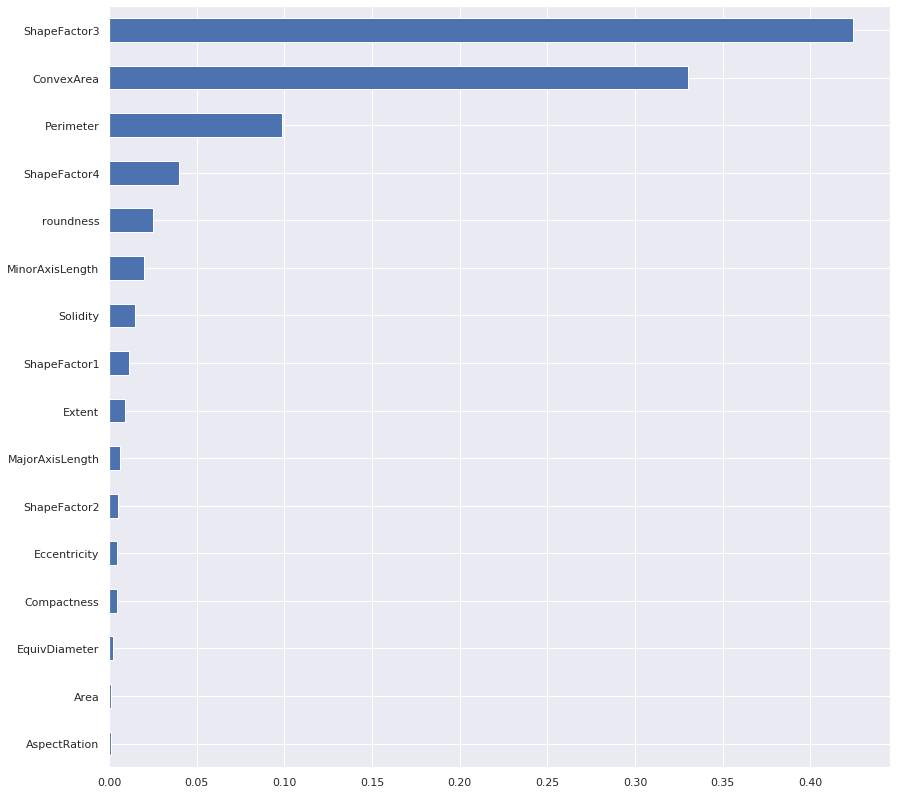

In [207]:
model_dt = m0.named_steps['decisiontreeclassifier']

importances = pd.Series(model_dt.feature_importances_, X_test.columns)
plt.figure(figsize=(14,14))
importances.sort_values().plot.barh();

In [208]:
from sklearn.pipeline import Pipeline

pipe_dt = Pipeline([
    ('preprocessing', RobustScaler()),
    ('dt', DecisionTreeClassifier(random_state=42, class_weight= None, max_depth = 16, 
                                  max_features=12, min_samples_leaf= 6)) 
])

In [209]:
pipe_dt.fit(X_train, y_train)
print('검증 정확도: ', pipe_dt.score(X_val, y_val))

검증 정확도:  0.9081679741578219


In [210]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    pipe_dt.named_steps['dt'],
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

X_val_transformed = pipe_dt.named_steps['preprocessing'].transform(X_val)

permuter.fit(X_val_transformed, y_val);

In [211]:
feature_names = X_val.columns.tolist()

In [212]:
eli5.show_weights(
    permuter, 
    top=None, 
    feature_names=feature_names 
)

Weight,Feature
0.2618 ± 0.0137,MajorAxisLength
0.1577 ± 0.0085,ShapeFactor1
0.0975 ± 0.0074,ShapeFactor3
0.0775 ± 0.0094,Perimeter
0.0763 ± 0.0098,ShapeFactor4
0.0755 ± 0.0088,roundness
0.0593 ± 0.0069,Compactness
0.0457 ± 0.0097,MinorAxisLength
0.0146 ± 0.0051,Solidity
0.0126 ± 0.0015,ConvexArea


In [213]:
pipe_rf = make_pipeline(
    RobustScaler(), 
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

params = {
    'randomforestclassifier__class_weight' : [None],
    'randomforestclassifier__max_depth' : [16],
    'randomforestclassifier__n_estimators' : [550],
    'randomforestclassifier__min_samples_leaf' : [4],
    'randomforestclassifier__max_features' : ['auto']
}

clf1 = GridSearchCV(
    pipe_rf,
    param_grid=params,
    cv=5,
    n_jobs=-1
    )

clf1.fit(X_train, y_train)


print('최적 하이퍼파라미터: ', clf1.best_params_)
print()
print('accuracy: ', clf1.best_score_)
print()
m1 = clf1.best_estimator_

m1.fit(X_val, y_val)
print('검증 정확도', m1.score(X_val, y_val))
print()
predict = m1.predict(X_val)
f1=f1_score(y_val, predict, average='weighted')

print("F1 score: {}" .format(f1))
print()

최적 하이퍼파라미터:  {'randomforestclassifier__class_weight': None, 'randomforestclassifier__max_depth': 16, 'randomforestclassifier__max_features': 'auto', 'randomforestclassifier__min_samples_leaf': 4, 'randomforestclassifier__n_estimators': 550}

accuracy:  0.9208500969377263

검증 정확도 0.9584679280110752

F1 score: 0.958391035244608



In [214]:
test_pred = m1.predict(X_test)

confusion = pd.DataFrame({'Class': test['Class'], 'Predict': test_pred})
# Create crosstab: ct
ct = pd.crosstab(confusion['Class'], confusion['Predict'])

print(classification_report(test_pred, test['Class']))
print()
ct

              precision    recall  f1-score   support

    BARBUNYA       0.89      0.93      0.91       256
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.92      0.94      0.93       321
    DERMASON       0.91      0.91      0.91       716
       HOROZ       0.94      0.96      0.95       366
       SEKER       0.96      0.96      0.96       407
        SIRA       0.87      0.85      0.86       539

    accuracy                           0.92      2709
   macro avg       0.93      0.93      0.93      2709
weighted avg       0.92      0.92      0.92      2709




Predict,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Class,,,,,,,
BARBUNYA,237,0,14,0,0,2,12
BOMBAY,0,104,0,0,0,0,0
CALI,16,0,301,0,8,0,1
DERMASON,0,0,0,648,0,7,54
HOROZ,1,0,6,5,351,0,9
SEKER,0,0,0,13,0,390,3
SIRA,2,0,0,50,7,8,460


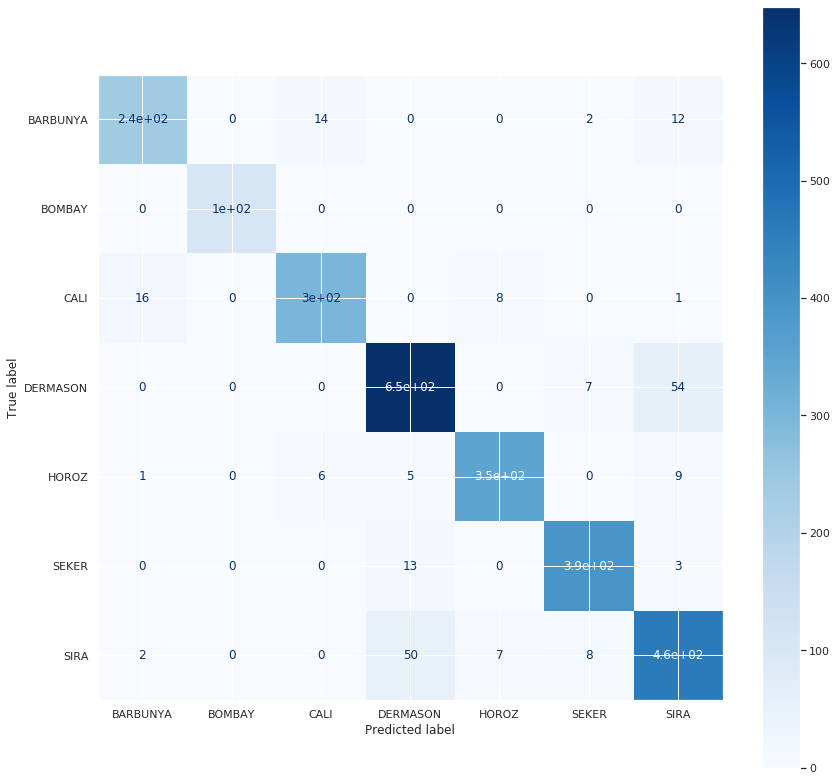

In [215]:
fig, ax = plt.subplots(figsize=(14, 14))
disp = plot_confusion_matrix(m1, X_test, y_test, 
                             display_labels=class_names, cmap=plt.cm.Blues, 
                              ax = ax,
                             )

In [216]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(data = X_train_scaled, columns=X_train.columns)

X_val_scaled = scaler.transform(X_val)
X_val_scaled = pd.DataFrame(data = X_val_scaled, columns=X_val.columns)

X_test_scaled = scaler.transform(X_test)
X_test_scaled = pd.DataFrame(data = X_test_scaled, columns=X_test.columns)

In [217]:
from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight('balanced', y_train)

In [218]:
model_xgb = XGBClassifier(
    n_estimators=1000,  
    max_depth=4,        
    learning_rate=0.1,
    scale_pos_weight=classes_weights,
    n_jobs=-1
)

eval_set = [(X_train_scaled, y_train), 
            (X_val_scaled, y_val)]

model_xgb.fit(X_train_scaled, y_train, 
          eval_set=eval_set,
          eval_metric='mlogloss',
          early_stopping_rounds=30
         ) 

[0]	validation_0-mlogloss:1.66736	validation_1-mlogloss:1.6712
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.46469	validation_1-mlogloss:1.4729
[2]	validation_0-mlogloss:1.30606	validation_1-mlogloss:1.31758
[3]	validation_0-mlogloss:1.1767	validation_1-mlogloss:1.19137
[4]	validation_0-mlogloss:1.06781	validation_1-mlogloss:1.08472
[5]	validation_0-mlogloss:0.973716	validation_1-mlogloss:0.992689
[6]	validation_0-mlogloss:0.892102	validation_1-mlogloss:0.913369
[7]	validation_0-mlogloss:0.821739	validation_1-mlogloss:0.844912
[8]	validation_0-mlogloss:0.758768	validation_1-mlogloss:0.78393
[9]	validation_0-mlogloss:0.702706	validation_1-mlogloss:0.730039
[10]	validation_0-mlogloss:0.652866	validation_1-mlogloss:0.682322
[11]	validation_0-mlogloss:0.608444	validation_1-mlogloss:0.639732
[12]	validation_0-mlogloss:0.568318	validation_1-mlog

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1,
              scale_pos_weight=array([1.04045618, 1.04045618, 1.46352584, ..., 1.18709766, 0.73393175,
       0.95462055]),
              seed=None, silent=None, subsample=1, verbosity=1)

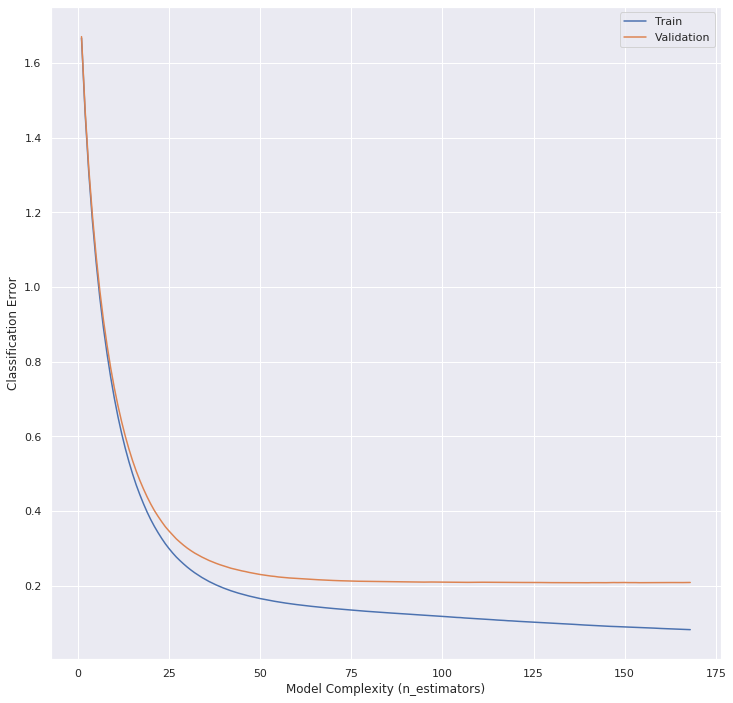

In [219]:
plt.figure(figsize=(12,12))
results = model_xgb.evals_result()
train_error = results['validation_0']['mlogloss']
val_error = results['validation_1']['mlogloss']

epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
#plt.ylim((0.15, 0.25)) # Zoom in
plt.legend();

In [220]:
print('검증 정확도', model_xgb.score(X_val_scaled, y_val))
print()
print(classification_report(y_val, model_xgb.predict(X_val_scaled)))

검증 정확도 0.9233964005537609

              precision    recall  f1-score   support

    BARBUNYA       0.93      0.93      0.93       211
      BOMBAY       1.00      1.00      1.00        84
        CALI       0.95      0.95      0.95       261
    DERMASON       0.91      0.92      0.91       567
       HOROZ       0.97      0.95      0.96       298
       SEKER       0.94      0.92      0.93       324
        SIRA       0.86      0.88      0.87       422

    accuracy                           0.92      2167
   macro avg       0.94      0.94      0.94      2167
weighted avg       0.92      0.92      0.92      2167



In [221]:
predict = model_xgb.predict(X_val_scaled)
f1=f1_score(y_val, predict, average='weighted')
print("F1 score: {}" .format(f1))

F1 score: 0.9235965710495074


In [222]:
test_pred = model_xgb.predict(X_test_scaled)

confusion = pd.DataFrame({'Class': test['Class'], 'Predict': test_pred})
# Create crosstab: ct
ct = pd.crosstab(confusion['Predict'], confusion['Class'])

print(classification_report(test_pred, test['Class']))
ct

              precision    recall  f1-score   support

    BARBUNYA       0.96      0.95      0.95       267
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.96      0.97      0.96       323
    DERMASON       0.93      0.92      0.92       719
       HOROZ       0.94      0.98      0.96       359
       SEKER       0.96      0.96      0.96       405
        SIRA       0.88      0.88      0.88       532

    accuracy                           0.94      2709
   macro avg       0.95      0.95      0.95      2709
weighted avg       0.93      0.94      0.93      2709



Class,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Predict,,,,,,,
BARBUNYA,254,0,9,0,1,3,0
BOMBAY,0,104,0,0,0,0,0
CALI,6,0,312,0,4,0,1
DERMASON,0,0,0,658,3,9,49
HOROZ,0,0,3,0,351,0,5
SEKER,1,0,0,10,0,388,6
SIRA,4,0,2,41,13,6,466


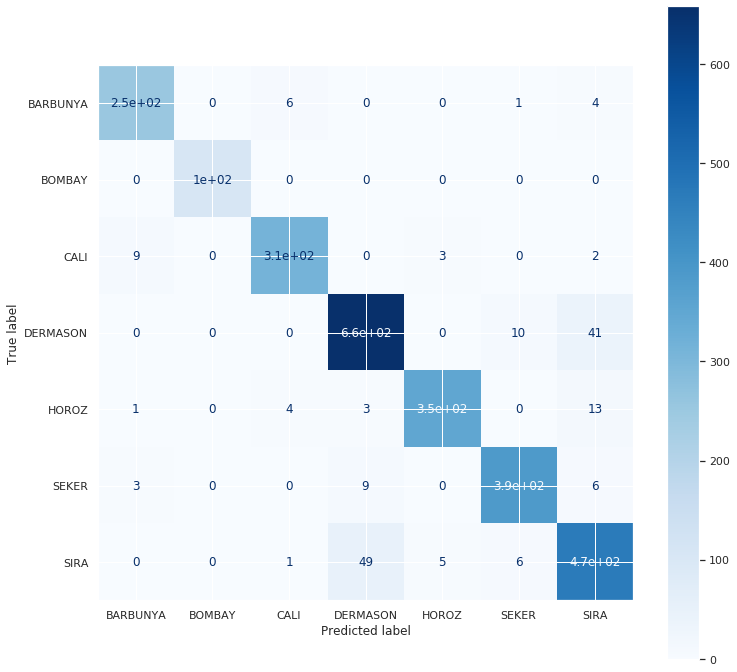

In [223]:
fig, ax = plt.subplots(figsize=(12, 12))
disp = plot_confusion_matrix(model_xgb, X_test_scaled, y_test, 
                             display_labels=class_names, cmap=plt.cm.Blues, 
                              ax = ax,
                             )

In [224]:
plt.rcParams['figure.dpi'] = 144

In [225]:
model_xgb.get_booster().feature_names = X_val_scaled.columns

In [226]:
import shap
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_train_scaled)

In [227]:
class_names = ['BARBUNYA',	'BOMBAY',	'CALI',	'DERMASON',	'HOROZ',	'SEKER',	'SIRA']

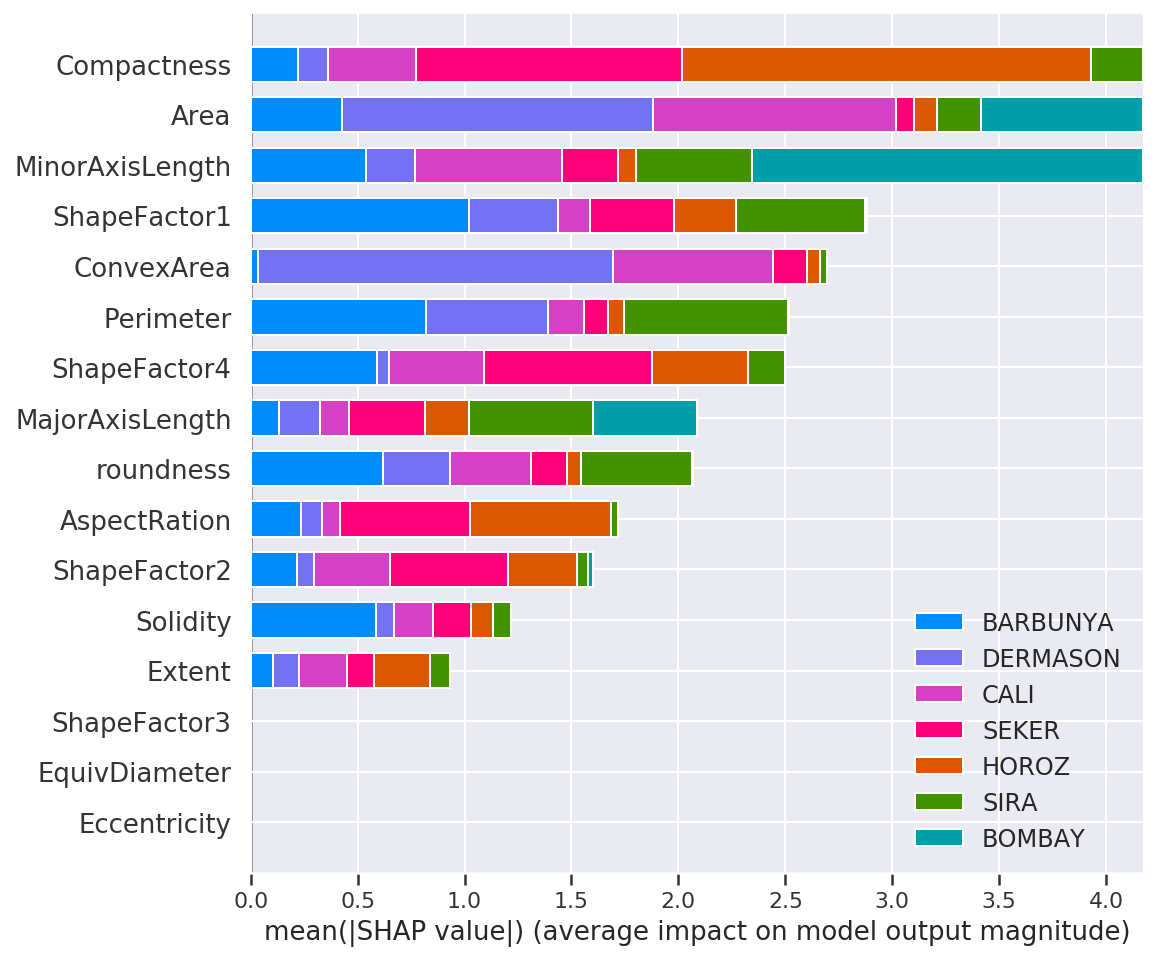

In [228]:
shap.summary_plot(shap_values, X_train_scaled.values, plot_type="bar",
                  class_names= class_names, feature_names = X_train_scaled.columns)

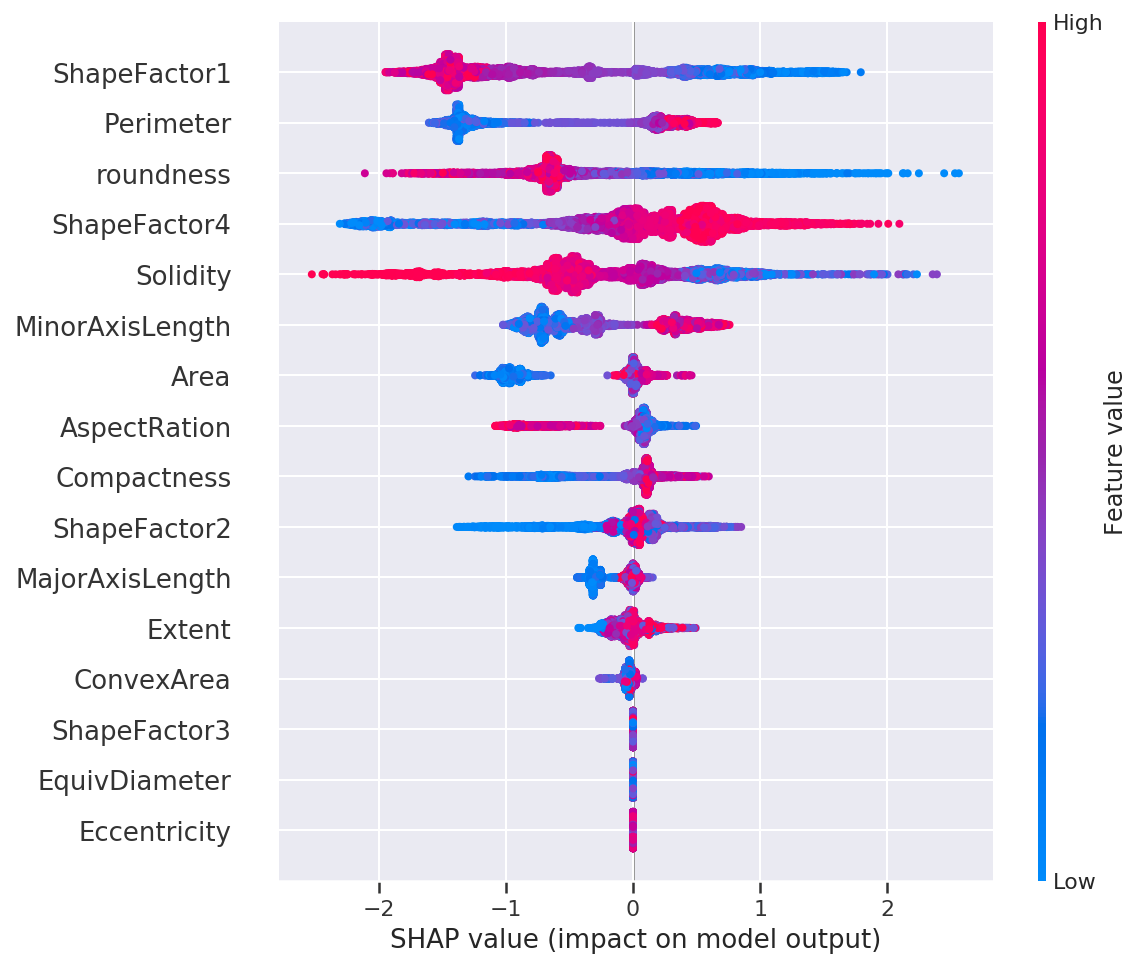

In [229]:
shap.summary_plot(shap_values[0], X_train_scaled.values, feature_names = X_train_scaled.columns)

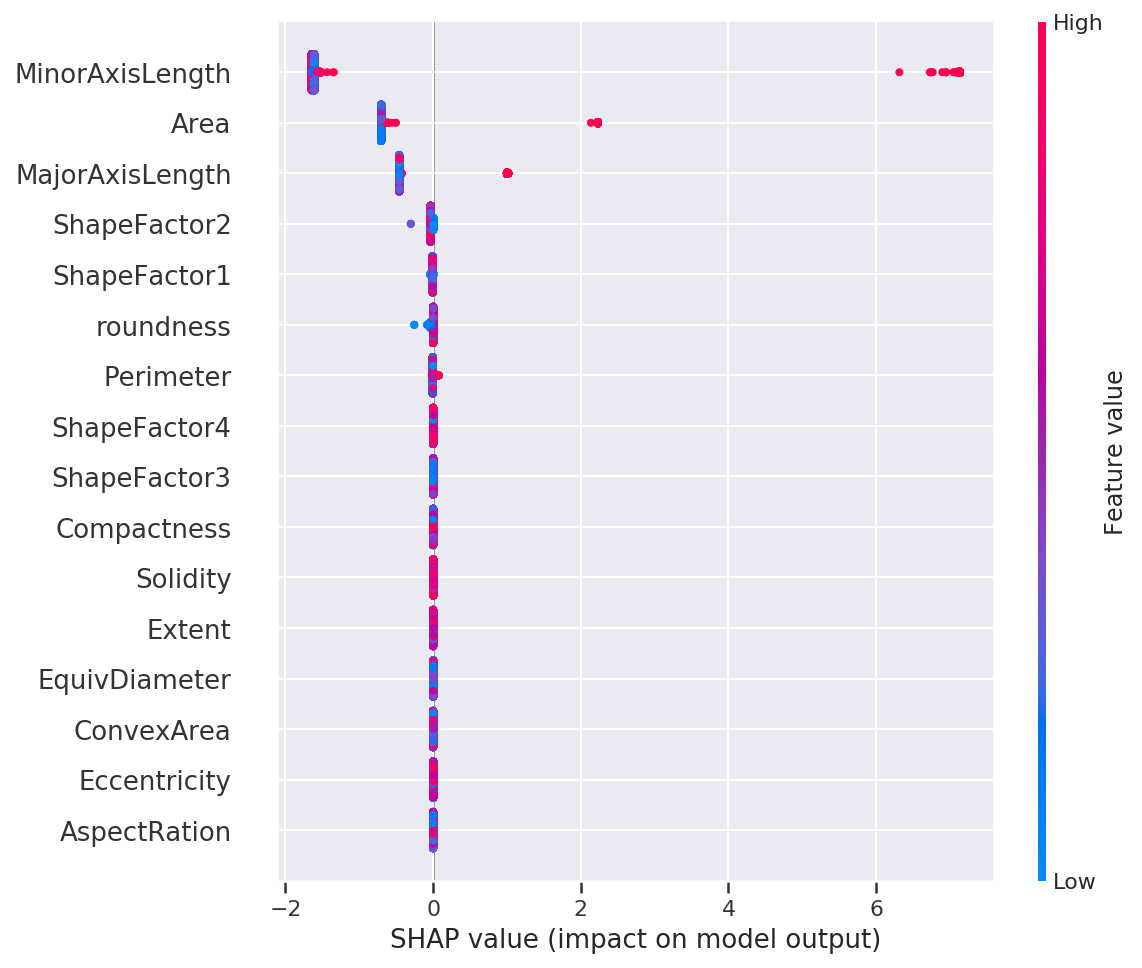

In [230]:
shap.summary_plot(shap_values[1], X_train_scaled.values, feature_names = X_train_scaled.columns)

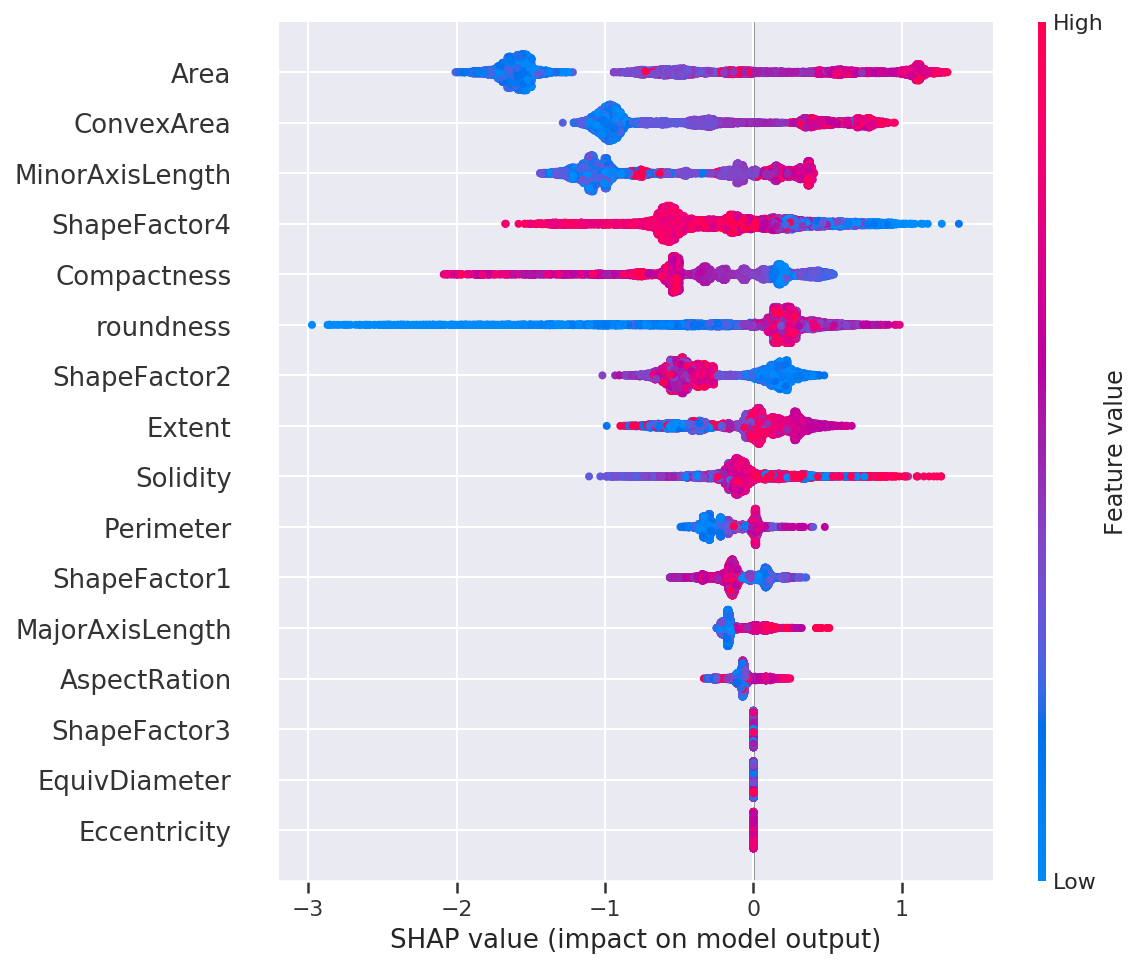

In [231]:
shap.summary_plot(shap_values[2], X_train_scaled.values, feature_names = X_train_scaled.columns)

In [232]:
shap.initjs()
i=0
shap.force_plot(explainer.expected_value[0], shap_values[0][i], X_train_scaled.values[i], feature_names = X_train_scaled.columns)

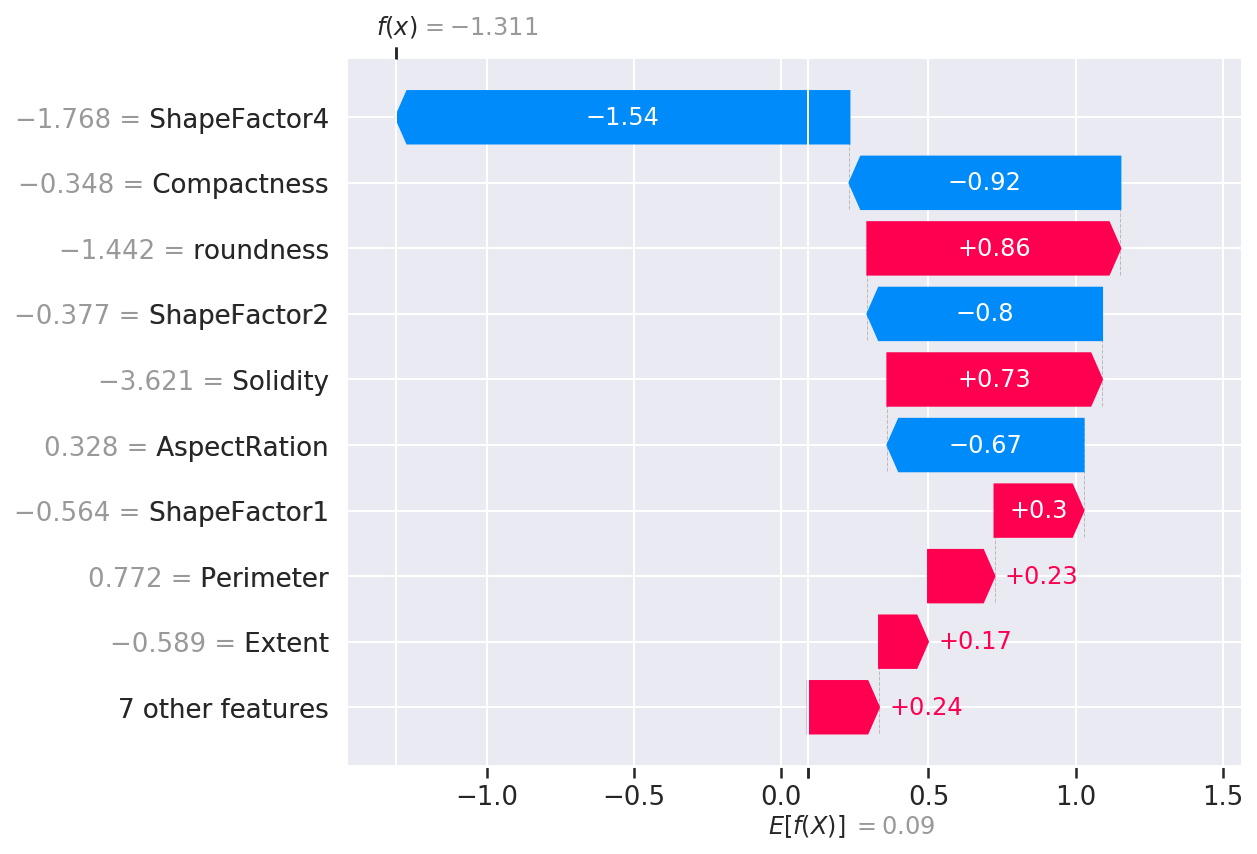

In [233]:
row = 0
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row], 
base_values=explainer.expected_value[0], data=X_test_scaled.iloc[row],  
feature_names=X_test.columns.tolist()))

In [234]:
lgbm_wrapper = LGBMClassifier(n_estimators=500)

evals = [(X_val_scaled, y_val)]
lgbm_wrapper.fit(X_train_scaled, y_train, early_stopping_rounds=30, eval_metric='logloss', eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_val_scaled)
pred_proba = lgbm_wrapper.predict_proba(X_val_scaled)[:,1]

[1]	valid_0's multi_logloss: 1.54009	valid_0's multi_logloss: 1.54009
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's multi_logloss: 1.35007	valid_0's multi_logloss: 1.35007
[3]	valid_0's multi_logloss: 1.20253	valid_0's multi_logloss: 1.20253
[4]	valid_0's multi_logloss: 1.08333	valid_0's multi_logloss: 1.08333
[5]	valid_0's multi_logloss: 0.982695	valid_0's multi_logloss: 0.982695
[6]	valid_0's multi_logloss: 0.89701	valid_0's multi_logloss: 0.89701
[7]	valid_0's multi_logloss: 0.823699	valid_0's multi_logloss: 0.823699
[8]	valid_0's multi_logloss: 0.759501	valid_0's multi_logloss: 0.759501
[9]	valid_0's multi_logloss: 0.702979	valid_0's multi_logloss: 0.702979
[10]	valid_0's multi_logloss: 0.652911	valid_0's multi_logloss: 0.652911
[11]	valid_0's multi_logloss: 0.609211	valid_0's multi_logloss: 0.609211
[12]	valid_0's multi_logloss: 0.570076	valid_0's multi_logloss: 0.570076
[13]	valid_0's multi_logloss: 0.53498	valid_0's multi_logloss: 0.53498
[14]	valid

In [235]:
predict = lgbm_wrapper.predict(X_val_scaled)
f1=f1_score(y_val, predict, average='weighted')
print("F1 score: {}" .format(f1))
print()
print()
confusion = pd.DataFrame({'Class': val['Class'], 'Predict': predict})
# Create crosstab: ct
ct = pd.crosstab( confusion['Class'], confusion['Predict'])

print(classification_report(predict, val['Class']))
print()
ct

F1 score: 0.9204175312474705


              precision    recall  f1-score   support

    BARBUNYA       0.93      0.92      0.93       214
      BOMBAY       1.00      1.00      1.00        84
        CALI       0.94      0.95      0.94       258
    DERMASON       0.91      0.92      0.91       561
       HOROZ       0.94      0.96      0.95       292
       SEKER       0.93      0.93      0.93       321
        SIRA       0.88      0.85      0.86       437

    accuracy                           0.92      2167
   macro avg       0.93      0.93      0.93      2167
weighted avg       0.92      0.92      0.92      2167




Predict,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Class,,,,,,,
BARBUNYA,197,0,8,0,2,0,4
BOMBAY,0,84,0,0,0,0,0
CALI,9,0,245,0,5,1,1
DERMASON,0,0,0,516,0,14,37
HOROZ,2,0,5,3,281,0,7
SEKER,3,0,0,4,0,300,17
SIRA,3,0,0,38,4,6,371


In [236]:
test_pred = lgbm_wrapper.predict(X_test_scaled)

confusion = pd.DataFrame({'Class': test['Class'], 'Predict': test_pred})
# Create crosstab: ct
ct = pd.crosstab(confusion['Class'], confusion['Predict'])

print(classification_report(test_pred, test['Class']))
print()
ct

              precision    recall  f1-score   support

    BARBUNYA       0.94      0.95      0.95       262
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.95      0.96      0.95       323
    DERMASON       0.91      0.92      0.92       705
       HOROZ       0.94      0.97      0.96       358
       SEKER       0.96      0.96      0.96       408
        SIRA       0.89      0.86      0.88       549

    accuracy                           0.93      2709
   macro avg       0.94      0.95      0.94      2709
weighted avg       0.93      0.93      0.93      2709




Predict,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
Class,,,,,,,
BARBUNYA,250,0,8,0,0,2,5
BOMBAY,0,104,0,0,0,0,0
CALI,10,0,309,0,4,0,3
DERMASON,0,0,0,648,0,10,51
HOROZ,0,0,5,4,349,0,14
SEKER,2,0,0,9,0,390,5
SIRA,0,0,1,44,5,6,471


In [237]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train) 
y_val_enc = le.fit_transform(y_val)
y_test_enc = le.fit_transform(y_test)

In [238]:
lgbm_clf = LGBMClassifier(n_estimators=500)

params = {'num_leaves': [32, 64],
          'max_depth':[128, 160],
          'min_child_samples':[60, 100],
          'sumsample':[0.8, 1]}

gridcv= GridSearchCV(lgbm_clf, param_grid=params, cv = 5)
gridcv.fit(X_train_scaled, y_train_enc, early_stopping_rounds=30, eval_metric='logloss', eval_set=[(X_train, y_train_enc),(X_val_scaled, y_val_enc)])

print()
print()
print('최적 파라미터:', gridcv.best_params_)


[1]	valid_0's multi_logloss: 1.89201	valid_0's multi_logloss: 1.89201	valid_1's multi_logloss: 1.55067	valid_1's multi_logloss: 1.55067
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's multi_logloss: 1.95265	valid_0's multi_logloss: 1.95265	valid_1's multi_logloss: 1.36475	valid_1's multi_logloss: 1.36475
[3]	valid_0's multi_logloss: 2.00905	valid_0's multi_logloss: 2.00905	valid_1's multi_logloss: 1.21975	valid_1's multi_logloss: 1.21975
[4]	valid_0's multi_logloss: 2.04682	valid_0's multi_logloss: 2.04682	valid_1's multi_logloss: 1.10136	valid_1's multi_logloss: 1.10136
[5]	valid_0's multi_logloss: 2.08426	valid_0's multi_logloss: 2.08426	valid_1's multi_logloss: 1.0016	valid_1's multi_logloss: 1.0016
[6]	valid_0's multi_logloss: 2.13735	valid_0's multi_logloss: 2.13735	valid_1's multi_logloss: 0.916741	valid_1's multi_logloss: 0.916741
[7]	valid_0's multi_logloss: 2.18533	valid_0's multi_logloss: 2.18533	valid_1's multi_logloss: 0.842968	valid_1's multi_lo

In [239]:
m2 = gridcv.best_estimator_

m2.fit(X_val_scaled, y_val_enc)
print('테스트 정확도', m2.score(X_test_scaled, y_test_enc))
print()
predict = m2.predict(X_test_scaled)
f1=f1_score(y_test_enc, predict, average='weighted')
print()
print("F1 score: {}" .format(f1))

테스트 정확도 0.9224806201550387


F1 score: 0.9227475033564652


In [240]:
test_pred

array(['BARBUNYA', 'SIRA', 'HOROZ', ..., 'CALI', 'SIRA', 'BARBUNYA'],
      dtype=object)

In [241]:
y_test_enc

array([0, 6, 4, ..., 2, 6, 0])

In [242]:
test_pred = m2.predict(X_test_scaled)

confusion = pd.DataFrame({'Class': y_test_enc, 'Predict': test_pred})
# Create crosstab: ct
ct = pd.crosstab(confusion['Class'], confusion['Predict'])

print(classification_report(test_pred, y_test_enc))
print()
ct

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       262
           1       1.00      1.00      1.00       104
           2       0.93      0.94      0.94       324
           3       0.90      0.91      0.91       707
           4       0.95      0.96      0.95       366
           5       0.95      0.96      0.96       400
           6       0.88      0.85      0.87       546

    accuracy                           0.92      2709
   macro avg       0.94      0.94      0.94      2709
weighted avg       0.92      0.92      0.92      2709




Predict,0,1,2,3,4,5,6
Class,,,,,,,
0,247,0,10,0,0,1,7
1,0,104,0,0,0,0,0
2,12,0,304,0,7,0,3
3,0,0,0,641,0,8,60
4,0,0,9,4,352,0,7
5,1,0,0,17,0,385,3
6,2,0,1,45,7,6,466


In [243]:
import tensorflow as tf
from tensorflow import keras

# 헬퍼(helper) 라이브러리를 임포트합니다
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.7.0


In [244]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

In [245]:
X_train_scaled.shape

(8667, 16)

In [246]:
len(y_train_enc)

8667

In [247]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [248]:
def build_model():
  model = Sequential()
  model.add(Dense(128, activation='selu', kernel_initializer='lecun_normal', input_dim=16))
  model.add(Dense(64, activation='selu', kernel_initializer='lecun_normal'))
  model.add(Dense(32, activation='selu', kernel_initializer='lecun_normal'))
  model.add(Dense(7, activation='softmax'))

  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [249]:
model = build_model()

In [250]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

In [251]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [252]:
history = model.fit(X_train_scaled, y_train_enc, epochs=1000, batch_size=32, verbose=2, 
                    validation_data=(X_val_scaled, y_val_enc), callbacks=[early_stopping])


Epoch 1/1000
271/271 - 1s - loss: 0.3587 - accuracy: 0.8782 - val_loss: 0.2257 - val_accuracy: 0.9169 - 1s/epoch - 5ms/step
Epoch 2/1000
271/271 - 1s - loss: 0.2258 - accuracy: 0.9196 - val_loss: 0.2581 - val_accuracy: 0.9119 - 645ms/epoch - 2ms/step
Epoch 3/1000
271/271 - 1s - loss: 0.2165 - accuracy: 0.9222 - val_loss: 0.2231 - val_accuracy: 0.9211 - 610ms/epoch - 2ms/step
Epoch 4/1000
271/271 - 1s - loss: 0.2172 - accuracy: 0.9205 - val_loss: 0.2251 - val_accuracy: 0.9192 - 559ms/epoch - 2ms/step
Epoch 5/1000
271/271 - 1s - loss: 0.2077 - accuracy: 0.9235 - val_loss: 0.2195 - val_accuracy: 0.9220 - 620ms/epoch - 2ms/step
Epoch 6/1000
271/271 - 1s - loss: 0.2095 - accuracy: 0.9244 - val_loss: 0.2245 - val_accuracy: 0.9197 - 614ms/epoch - 2ms/step
Epoch 7/1000
271/271 - 1s - loss: 0.2036 - accuracy: 0.9268 - val_loss: 0.2215 - val_accuracy: 0.9216 - 546ms/epoch - 2ms/step
Epoch 8/1000
271/271 - 1s - loss: 0.2030 - accuracy: 0.9259 - val_loss: 0.2142 - val_accuracy: 0.9234 - 538ms/epoc

In [253]:
model.evaluate(X_val_scaled, y_val_enc)

68/68 [==============================] - 0s 1ms/step - loss: 0.2269 - accuracy: 0.9192


[0.226882666349411, 0.9192432165145874]

In [254]:
# model = build_model()
# history = model.fit(X_train_scaled, y_train_enc, batch_size=32, epochs=200, validation_split=0.25, verbose=2)


In [255]:
model.evaluate(X_test_scaled, y_test_enc)

85/85 [==============================] - 0s 1ms/step - loss: 0.1809 - accuracy: 0.9306


[0.18089023232460022, 0.9306017160415649]

In [256]:
y_pred_label = np.argmax(y_pred_proba, axis=-1)
y_pred_label[:10]

array([0, 6, 4, 3, 2, 3, 4, 3, 3, 5])

In [257]:
y_test_enc[:10]

array([0, 6, 4, 3, 2, 3, 4, 3, 3, 5])

In [258]:
f1=f1_score(y_test_enc, y_pred_label, average='weighted')
print("F1 score: {}" .format(f1))

# confusion = pd.DataFrame({'Class': ['Class'], 'Predict': predict})
# # Create crosstab: ct
# ct = pd.crosstab(confusion['Predict'], confusion['Class'])
print()
print(classification_report(y_pred_label, y_test_enc))


F1 score: 0.9335342736714523

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       270
           1       1.00      1.00      1.00       104
           2       0.95      0.96      0.95       323
           3       0.92      0.93      0.92       701
           4       0.94      0.96      0.95       365
           5       0.95      0.98      0.97       391
           6       0.91      0.86      0.88       555

    accuracy                           0.93      2709
   macro avg       0.95      0.95      0.95      2709
weighted avg       0.93      0.93      0.93      2709



In [259]:
confusion = pd.DataFrame({'Class': y_test_enc, 'Predict': y_pred_label})
# Create crosstab: ct
ct = pd.crosstab(confusion['Predict'], confusion['Class'])
ct

Class,0,1,2,3,4,5,6
Predict,,,,,,,
0,255,0,7,0,0,7,1
1,0,104,0,0,0,0,0
2,5,0,309,0,9,0,0
3,0,0,0,649,3,6,43
4,0,0,7,4,349,0,5
5,0,0,0,5,0,385,1
6,5,0,3,51,11,8,477


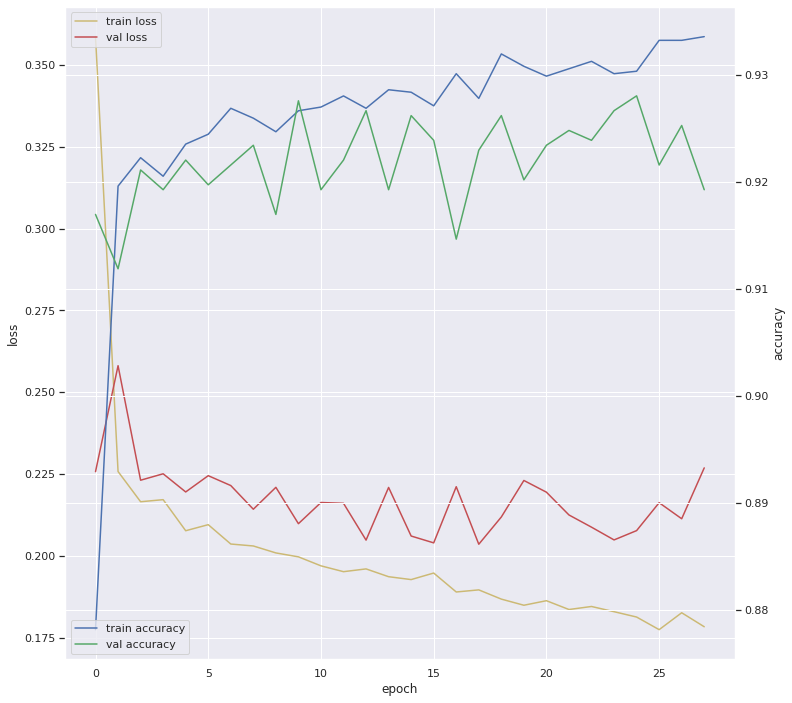

In [260]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(12,12))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label = 'train loss')
loss_ax.plot(history.history['val_loss'], 'r', label = 'val loss')

acc_ax.plot(history.history['accuracy'], 'b', label = 'train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'g', label = 'val accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.show()

In [ ]:
'''
pipe = make_pipeline(
    RobustScaler(),
    DecisionTreeClassifier(random_state=42)
)

params = {
    'decisiontreeclassifier__class_weight' : [None],
    'decisiontreeclassifier__max_depth' : [16],
    'decisiontreeclassifier__min_samples_leaf' : [5,6,7],
    #'decisiontreeclassifier__min_samples_split' : [2,3,4,5,6],
    'decisiontreeclassifier__max_features':[12]
}

clf1 = GridSearchCV(
    pipe,
    param_grid=params,
    cv=5,
    n_jobs=-1
    )

clf1.fit(X_train, y_train)


print('최적 하이퍼파라미터: ', clf1.best_params_)
print('accuracy: ', clf1.best_score_)

m1 = clf1.best_estimator_

m1.fit(X_val, y_val)
print('검증 정확도', m1.score(X_val, y_val))

predict = m1.predict(X_val)
f1=f1_score(y_val, predict, average='weighted')

print("F1 score: {}" .format(f1))



pipe = make_pipeline(
    RobustScaler(),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

params = {
    'randomforestclassifier__class_weight' : [None],
    'randomforestclassifier__max_depth' : [14,15,16,17,18],
    'randomforestclassifier__n_estimators' : [450,500,550],
    'randomforestclassifier__min_samples_leaf' : [2,3,4,5,6],
    'randomforestclassifier__max_features' : ['auto']
}

clf1 = GridSearchCV(
    pipe,
    param_grid=params,
    cv=5,
    n_jobs=-1
    )

clf1.fit(X_train, y_train)


print('최적 하이퍼파라미터: ', clf1.best_params_)
print('accuracy: ', clf1.best_score_)

m1 = clf1.best_estimator_

m1.fit(X_val, y_val)
print('검증 정확도', m1.score(X_val, y_val))

predict = m1.predict(X_val)
f1=f1_score(y_val, predict, average='weighted')

print("F1 score: {}" .format(f1))

pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=200
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                 )
)

pipe.fit(X_train, y_train);


print('최적 하이퍼파라미터: ', clf1.best_params_)
print('accuracy: ', clf1.best_score_)

m1 = clf1.best_estimator_

m1.fit(X_val, y_val)
print('검증 정확도', m1.score(X_val, y_val))

predict = m1.predict(X_val)
f1=f1_score(y_val, predict, average='weighted')

print("F1 score: {}" .format(f1))

from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight('balanced', y_train)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

model = LGBMClassifier(
    n_estimators=1000,
    max_depth=16,
    min_child_samples=20,
    num_leaves=144,
    learning_rate=0.2,
    scale_pos_weight=classes_weights,
    early_stopping_rounds=30,

    n_jobs=-1
)

eval_set = [(X_train_scaled, y_train),
            (X_val_scaled, y_val)]

model.fit(X_train_scaled, y_train,
          eval_set=eval_set,
          eval_metric='mlogloss',
          early_stopping_rounds=30
         )

params = {'learning_rate': 0.01,
          'max_depth': 16,
          'boosting': 'gbdt',
          'objective': 'classification',
          'metric': 'auc',
          'is_training_metric': True,
          'num_leaves': 144,
          'feature_fraction': 0.9,
          'bagging_fraction': 0.7,
          'bagging_freq': 5,
          'scale_pos_weight': classes_weights,
          'seed':2021}

import lightgbm as lgb

train_ds = lgb.Dataset(X_train_scaled, label = y_train)
test_ds = lgb.Dataset(X_val_scaled, label = y_val)

model = lgb.train(params, train_ds, 1000, test_ds, verbose_eval=100, early_stopping_rounds=100)

predict_train = model.predict(X_train_scaled)
predict_val = model.predict(X_val_scaled)
'''